## NEMO ocean data loading and plotting with Iris

In [1]:
import os
import os.path

import cartopy.crs as ccrs
import iris
import iris.analysis
import iris.quickplot as qplt
import iris.util
import matplotlib.pyplot as plt

In [2]:
TOP_LEVEL_DIRECTORY = "/gws/nopw/j04/eerie/public/model/data/HadGEM3-GC31-HM/"

In [3]:
def load_callback_nemo(cube, field, filename):
    """
    An Iris load callback function to delete a few metadata items that will
    prevent the files from being merged into a single cube.

    The time_counter dimension is removed and time is promoted to be a
    dimension coordinate.
    """
    attributes_to_remove = [
        "TimeStamp",
        "file_name",
        "history",
        "name",
        "timeStamp"
    ]
    for attr_name in attributes_to_remove:
        del(cube.attributes[attr_name])

    # Fix the various times coordinates
    cube.remove_coord("time_counter")
    iris.util.promote_aux_coord_to_dim_coord(cube, "time")

In [4]:
tos_files = [
    "nemo_az094o_1s_20080301-20080601_grid-T_tos.nc.trimmed.nc",
    "nemo_az094o_1s_20080601-20080901_grid-T_tos.nc.trimmed.nc",
    "nemo_az094o_1s_20080901-20081201_grid-T_tos.nc.trimmed.nc"
]

In [5]:
tos_paths = [os.path.join(TOP_LEVEL_DIRECTORY, file_path) for file_path in tos_files]
cubes = iris.load(tos_paths, callback=load_callback_nemo)
tos = cubes.concatenate_cube()

/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'tos'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'tos'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'tos'
  warnings.warn(


In [6]:
print(tos)

sea_surface_temperature / (degree_C) (time: 3; -- : 1205; -- : 1440)
    Dimension coordinates:
        time                              x       -          -
    Auxiliary coordinates:
        latitude                          -       x          x
        longitude                         -       x          x
    Cell methods:
        mean                         time (900 s)
    Attributes:
        Conventions                  'CF-1.5'
        NCO                          'netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = ...
        description                  'ocean T grid variables'
        ibegin                       0
        interval_operation           '900 s'
        interval_write               '1 month'
        jbegin                       0
        ni                           1442
        nj                           101
        online_operation             'average'
        production                   'An IPSL model'
        title                   

We have now loaded the muliple netCDF files into a single Iris cube. We can now do something interesting with this loaded data.

### Plotting time slices

Plot the first time point. Because NEMO data is on the ORCA tri-polar grid it needs to be projected onto a suitable projection.

/opt/jaspy/lib/python3.10/site-packages/iris/analysis/cartography.py:633: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(


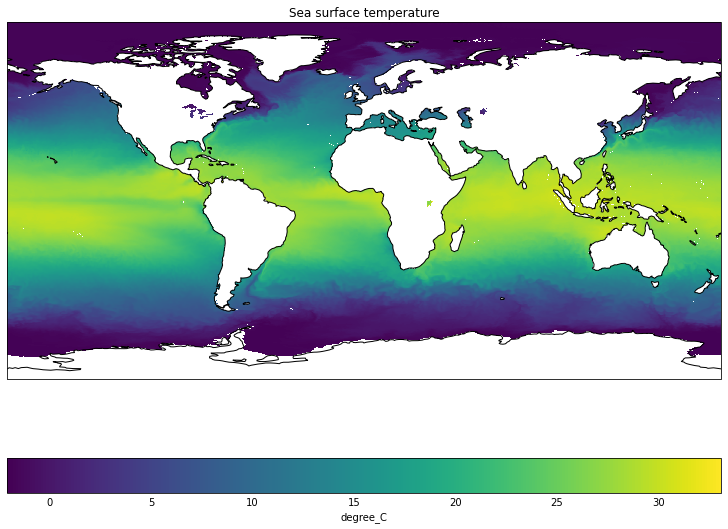

In [7]:
fig = plt.figure(figsize=[12.8, 9.6])
projected_cube, extent = iris.analysis.cartography.project(
    tos[0, ...], ccrs.PlateCarree()
)
qplt.pcolormesh(projected_cube)
plt.draw()
__ = plt.gca().coastlines()  # __ hides the return value in Notebooks

### Time mean

Calculate the area weighted global mean at each time slice and plot this series.

In [8]:
global_mean = tos.collapsed(
        ["latitude", "longitude"], iris.analysis.MEAN
    )

/opt/jaspy/lib/python3.10/site-packages/iris/cube.py:3696: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2214: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2214: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [9]:
print(tos.summary(shorten=True))
print(global_mean.summary(shorten=True))

sea_surface_temperature / (degree_C) (time: 3; -- : 1205; -- : 1440)
sea_surface_temperature / (degree_C) (time: 3)


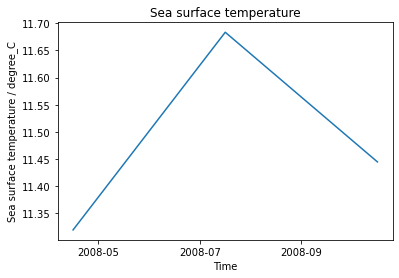

In [10]:
fig = plt.figure()
qplt.plot(global_mean)
plt.draw()